# **Classification Algorithm : Banking Churn Prediction**


---


## **Assignment Overview**

The objective of this project is to build a **classification model** to predict whether a customer will **churn** (leave the bank) or not. This is a crucial business problem as retaining existing customers is often more cost-effective than acquiring new ones. We will use a dataset with various customer attributes to train a model that can identify customers at risk of churning, allowing for proactive intervention.

The process will follow a standard machine learning workflow:
1.  **Exploratory Data Analysis (EDA):** We'll start by exploring the data to understand the distribution of variables, identify any relationships, and check for imbalances in our target variable (`churn`).
2.  **Data Pre-processing:** This is a critical step where we'll clean and transform the data. This includes handling missing values, encoding categorical variables, and scaling numerical features to prepare them for the model.
3.  **Model Building:** We'll select and train a suitable classification algorithm (e.g., Logistic Regression, Decision Tree, Random Forest) on our prepared data.
4.  **Evaluation:** We'll evaluate our model's performance using appropriate metrics like accuracy, precision, recall, and a confusion matrix to understand how well it predicts customer churn.

**NOTE : We'll use `plotly` for data visualisations**

---

## **Column Specifications**

Here is a detailed breakdown of the columns in the `Banking_churn_prediction.csv` dataset:

| Column Name | Description | Data Type |
| :--- | :--- | :--- |
| **customer_id** | Unique identifier for each customer. | Numerical |
| **vintage** | The number of days the customer has been with the bank. | Numerical |
| **age** | The customer's age. | Numerical |
| **gender** | The customer's gender. | Categorical |
| **dependents** | Number of dependents the customer has. | Numerical |
| **occupation** | The customer's occupation. | Categorical |
| **city** | The city of the customer. | Categorical |
| **customer_nw_category** | The net worth category of the customer (1, 2, or 3). | Categorical |
| **branch_code** | The bank branch where the customer has an account. | Categorical |
| **current_balance** | Current balance in the customer's account. | Numerical |
| **previous_month_end_balance** | Balance at the end of the previous month. | Numerical |
| **average_monthly_balance_prevQ** | Average monthly balance in the previous quarter. | Numerical |
| **average_monthly_balance_prevQ2** | Average monthly balance in the quarter before the previous one. | Numerical |
| **current_month_credit** | Total credit transactions in the current month. | Numerical |
| **previous_month_credit** | Total credit transactions in the previous month. | Numerical |
| **current_month_debit** | Total debit transactions in the current month. | Numerical |
| **previous_month_debit** | Total debit transactions in the previous month. | Numerical |
| **current_month_balance** | The current month's end balance. | Numerical |
| **previous_month_balance** | The previous month's end balance. | Numerical |
| **churn** | **Target Variable**: `0` for no churn, `1` for churn. | Categorical (Binary) |
| **last_transaction** | Date of the last transaction. This may be a string and need to be converted to a date. | Categorical |

# **Initial Setup**

In [ ]:
!pip install lifelines

In [ ]:
#
# Import Libraries
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from lifelines import KaplanMeierFitter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from google.colab import files

#
# Set Pandas display format for floats
#
pd.options.display.float_format = '{:.2f}'.format

#
# Set NumPy's print options to suppress scientific notation and set precision.
# 'suppress  = True' - Prevents the use of scientific notation.
# 'precision = 2'    - Sets the number of decimal places to display.
#
np.set_printoptions(suppress = True, precision = 2)

In [ ]:
#
# Upload the dataset 'Banking_churn_prediction.csv'
#
uploadOutput = files.upload()

# **Load Data**

In [ ]:
df = pd.read_csv('Banking_churn_prediction.csv')
df.head()

In [ ]:
print("Shape = {}".format(df.shape))
print("Size  = {}".format(df.size))

In [ ]:
df.info()

**Found Missing Data on**
* `gender`
* `dependents`
* `occupation`
* `city`

# **Statistical Details**

In [ ]:
df.describe()

In [ ]:
df.describe().T

In [ ]:
df.describe(include = 'all')

# **Pre-Processing**

## **Check Missing Values**

In [ ]:
#
# Find only columns that has missing value
#

# df.isnull().sum().sort_values(ascending = False)
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)

In [ ]:
#
# Get the rows that has missing values
#
missing_value_rows = df[df.isnull().any(axis = 1)]
# print(missing_value_rows) # Commented out print as the output is large

In [ ]:
#
# Percentage of missing values
#
missingValueRows = df.isnull().sum()
percentMissing   = ((df.isnull().sum() / df.shape[0]) * 100)

missingValueRows = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)
percentMissing   = ((df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False) / df.shape[0]) * 100)

# print("Missig Values")
# print("=============")
# print(missingValueRows)

# print("")

# print("Percent Missing")
# print("===============")
# print(percentMissing)

missingData = {
                'Missing Value Rows': missingValueRows,
                'Missing Percentage': percentMissing
              }
missingDataFrame = pd.DataFrame(missingData)
missingDataFrame

## **Check Duplicates**

In [ ]:
#
# Get Duplicate Count
#
df.duplicated().sum()

In [ ]:
#
# Get Duplicate Row
#
duplicatedRows = df[df.duplicated()]
print(duplicatedRows)

**No Duplicates**

## **Check Negative Values**

In [ ]:
#
# Find Colums that has negative values
#
numericalColumns = df.select_dtypes(include = np.number).columns

for col in numericalColumns:
  if df[col].min() < 0:
    print(f"Column '{col}' has negative values. Min value: {df[col].min()}")

print("")
print("Negative Values Checks Done")

**Negative Values are all in Account Balance. Accpetable. No fix required.**

In [ ]:
#
# Take a copy of the dataframe before making any changes
#
dfCopied = df.copy()

## **Data Imputation**

** Imputation Strategy**

**dependents (Numerical, Count)**
* **Imputation Method**  
Impute with 0

* **Why?**  
Your assumption is a strong and logical one. Since this column represents the count of dependents, a missing value most likely means the customer either has no dependents or chose not to declare them. In either case, 0 is the most reasonable and practical value to fill in.

**city (Categorical)**
* **Imputation Method**  
Impute with the **mode** (the most frequent city)

* **Why?**  
This is a key distinction. city is a categorical column, not a numerical one, even though the dataset shows city as a `float`, but its values, like **187 or 146**, are not **quantities**. They are likely **city codes that act as categorical labels**. We cannot use the median or mean, as those are statistical measures for numbers. The mode is the standard approach for imputing categorical data. By filling in the most common city, we are making a statistically sound assumption that is least likely to distort the original distribution of the data.

**gender (Categorical)**
* **Imputation Method**  
Impute with the **mode** (the most frequent gender)

* **Why?**  
Like city, gender is a categorical variable. The mode is the correct statistical measure for this. Given the low percentage of missing values (1.85%), filling with the most frequent gender will have a minimal impact on our final model.

**occupation (Categorical)**
* **Imputation Method**  
Impute with the **mode** (the most frequent occupation).

* **Why?**  
With only 0.28% of values missing, this is the least impactful imputation. Using the mode is the standard and most reliable way to handle missing values in a categorical feature.

In [ ]:
df['city'].mode()

**Converting `city`, `gender` and `occupation` as categorical columns **


---

**Somewhere from Google**

It is a must in this case. Not converting those columns to the `object` (or categorical) data type will very likely cause issues down the line.

Here's a detailed explanation of why it's necessary:

**Why Data Types Matter**  
When you load a CSV file into a Pandas DataFrame, Pandas automatically infers the data type for each column.

* The `gender` and `occupation` columns contain text, so Pandas correctly interprets them as the `object` data type.

* The `city` column, however, contains numbers. Because there are some `NaN` (missing) values, Pandas typically defaults to a `numeric` type that can handle floating-point numbers, such as `float64`. It treats the city codes `187`, `146`, etc., as numerical values, not as categorical labels.

The issue arises when you get to the **model training** phase. Most machine learning models, especially those from libraries like Scikit-learn, require all input features to be numerical. You'll need to use a technique like **One-Hot Encoding** to convert these categorical columns into a numerical format that the model can understand.

**The Problem with Not Converting `city`**  
If you don't explicitly convert `city` to an `object` type, it will be treated as a numerical column. When you apply **One-Hot Encoding** to your features, you'll be telling the encoder to operate on the `gender` and `occupation` columns (which are correctly identified as categorical), but it will skip the city column because it's a float.

The model will then see the city numbers as a continuous, ordered variable. For example, it might incorrectly assume that a city with a code of `500` is "greater than" a city with a code of `100`, and that this numerical difference has some predictive meaning. This is a fundamental misunderstanding of the data, as these codes are just arbitrary labels, not values.

The code `df[col] = df[col].astype('object')` is a simple but crucial step to ensure Pandas correctly recognizes `city` as a categorical feature, allowing it to be handled properly during subsequent preprocessing steps like **One-Hot Encoding.**



---


**Why One-Hot Encoding is Needed for city**  
If we didn't one-hot encode the `city` column, the model would interpret it as **continuous numerical data**. It might, for example, assign a higher weight to city codes with larger numbers, which makes no sense from a business or a data perspective. The model would think there's a **linear relationship** where there isn't one. This can lead to the model making incorrect predictions and can hurt its overall performance.

One-hot encoding solves this problem by creating a new binary column for each unique city code. For example, instead of a single `city` column with values like `146` or `187`, you would get new columns like `city_146`, `city_187`, etc. A value of 1 in city_146 would indicate that the customer is from that city, and 0 otherwise.

This tells the model that each city is a separate, independent category, which is the correct way to represent this information.


---


**Curse of dimensionality**  
**One-hot encoding** the `city` column will create a large number of new features, one for each unique city code. This can potentially lead to a less efficient model and may cause issues like overfitting, where the model learns the training data too well but struggles to generalize to new, unseen data.

However, despite this, it's a necessary step because the alternative is much worse. If we treat the `city` codes as a single numerical column, the model would assume that the distance between city `100` and `200` is the same as the distance between city `500` and `600`, which is not true. These numbers are just arbitrary labels. **One-hot encoding** avoids this fundamental and incorrect assumption by treating each city as a separate, distinct entity.

For this assignment, the trade-off is worth it because it ensures the model correctly interprets the data. In more complex real-world scenarios with thousands of unique cities, you might explore techniques like **dimensionality reduction after one-hot encoding** to address the issue.

In [ ]:
#
# Impute missing values
# Using the strategy above
#
df['dependents'] = df['dependents'].fillna(0)

#
# Columns city, gender, occupation, customer_nw_category, branch_code
#    These are categorical, even if 'city' is currently a float.
#    First, ensure they are treated as categorical columns.
#
for col in ['city', 'gender', 'occupation', 'customer_nw_category', 'branch_code']:
  df[col] = df[col].astype('category')

#
# Impute missing values for categorical columns
# mode - Returns a series (see Above), so we need to specify the index [0]
#
df['city']       = df['city'].fillna(df['city'].mode()[0])
df['gender']     = df['gender'].fillna(df['gender'].mode()[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])

In [ ]:
df.info()

In [ ]:
#
# Check missing values again
#
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)

**Imputation Done. No missing values now**

In [ ]:
#
# Finally create churn_status Column
#   0 = Retained
#   1 = Churned
#
# We can use it charts for better readability
#

#
# Convert the 'churn' column to a more descriptive string for plotting
#
# Create the new 'churn_status' column
# df['churn_status'] = df['churn'].apply(lambda x: 'Churned' if x == 1 else 'Retained')
df['churn_status'] = df['churn'].map({0: 'Retained', 1: 'Churned'})
df.head()

# **Data Visualisation - Part 1**

## **Distribution of Churn**

In [ ]:
#
# Create an interactive histogram of the target variable 'churn'
#
# The 'churn' column is our target variable with values 0 (no churn) and 1 (churn).
# We use px.histogram to count the occurrences of each value.
#
fig = px.histogram(
                    df,
                    x                  = 'churn_status',
                    title              = 'Distribution of Churn',
                    labels             = {'churn_status': 'Churn Status'},
                    color              ='churn_status',
                    color_discrete_map = {'Retained': 'blue', 'Churned': 'red'},
                    nbins              = 2
                  )

#
# Change y-axis label
#
fig.update_layout(
                   yaxis_title     = 'Number of Customers',
                   title_font_size = 20
                 )

fig.show()

## **Observation**
The most significant takeaway is the class **imbalance in our dataset**. The number of customers who did not churn (0) is overwhelmingly larger than the number of customers who did churn (1).

This means our **model will have a lot more examples of non-churning customers to learn from than churning customers**. If we don't address this, a model could achieve high accuracy simply by predicting that no one ever churns. For example, if 95% of our customers did not churn, a model that always predicts "no churn" would be 95% accurate, but it would be useless for identifying at-risk customers.

## **Churn by Gender**

In [ ]:
#
# Create a histogram to show the relationship between gender and churn.
# The 'color' parameter automatically creates a grouped bar chart,
# showing the counts of churn for each gender.
#
fig = px.histogram(
                    df,
                    x                  = 'gender',
                    title              = 'Distribution of Churn by Gender',
                    labels             = {
                                           'gender'       : 'Gender',
                                           'churn_status' : 'Churn Status'
                                         },
                    color              = 'churn_status',
                    barmode            = 'group', # Use 'group' to place bars side-by-side for better comparison
                    color_discrete_map = {'Retained': 'blue', 'Churned': 'red'},
                    nbins              = 2
                  )

#
# Change y-axis label
#
fig.update_layout(
                   yaxis_title     = 'Number of Customers',
                   title_font_size = 20
                 )

fig.show()

## **Observation**
Looking at the raw counts, the number of males who churned  and the number of females who churned are quite close. So the difference in the raw number of churned customers isn't very large.

However, to get a clearer picture, it's more useful to look at the churn rate, which is the percentage of customers in each group who churned.

**Here's my observation**

* **Total Customers**  
There are more male customers overall than female customers in this dataset, as indicated by the much taller blue bar for males.
* **Churn Rate**  
When you calculate the percentage of customers who churned within each gender group, the churn rate for males is actually slightly higher than for females.

So while the absolute numbers are similar, the data suggests that a male customer is slightly more likely to churn than a female customer. It's a subtle but important distinction that could be meaningful for the business.

## **Churn by Gender - By Percentage**

In [ ]:
#
# With a lot of help from the Internet
#

#
# Ensure the 'gender' and 'churn' columns are clean and correctly typed
#
df['gender'] = df['gender'].str.strip()
df['churn']  = df['churn'].astype(int)

#
# Calculate the counts for each gender and churn status
#
genderCounts   = df.groupby('gender')['churn'].count()
retainedCounts = df[df['churn'] == 0].groupby('gender')['churn'].count()
churnedCounts  = df[df['churn'] == 1].groupby('gender')['churn'].count()

#
# Calculate the churn and retention percentages
#
retainedPercent = (retainedCounts / genderCounts) * 100
churnedPercent  = (churnedCounts / genderCounts) * 100

#
# Get total and gender-specific counts for the title
#
totalCustomers = len(df)
maleCount      = genderCounts.get('Male', 0)
femaleCount    = genderCounts.get('Female', 0)

#
# Create the figure with plotly.graph_objects
#
fig = go.Figure()

#
# Add a bar for retained customers with hover text showing counts
#
fig.add_trace(
               go.Bar(
                       x              = retainedPercent.index,
                       y              = retainedPercent.values,
                       name           = 'Retained',
                       marker_color   = 'blue', # '#4C72B0', # A nice blue color
                       text           = retainedPercent.round(2), # Add text labels to the bars
                       textposition   = 'auto',
                       insidetextfont = {'color': 'white'},
                       hovertemplate  = '<b>%{x}</b><br>Retained: %{y:.2f}%<br>Count: ' + retainedCounts.astype(str) + '<extra></extra>'
                     )
             )

#
# Add a bar for churned customers with hover text showing counts
#
fig.add_trace(
               go.Bar(
                       x              = churnedPercent.index,
                       y              = churnedPercent.values,
                       name           = 'Churned',
                       marker_color   = 'red', # '#E58686', # A nice red color
                       text           = churnedPercent.round(2), # Add text labels to the bars
                       textposition   = 'auto',
                       insidetextfont = {'color': 'white'},
                       hovertemplate  = '<b>%{x}</b><br>Churned: %{y:.2f}%<br>Count: ' + churnedCounts.astype(str) + '<extra></extra>'
                     )
             )

#
# Update the layout for a cleaner look
#
fig.update_layout(
                   title_text      = f'Churn Percentage by Gender<br><sup>Total Customers: {totalCustomers} | Male: {maleCount} | Female: {femaleCount}</sup>',
                   xaxis_title     = 'Gender',
                   yaxis_title     = 'Percentage of Customers',
                   barmode         = 'group',
                   yaxis_range     = [0, 100], # Explicitly set y-axis range from 0 to 100%
                   title_font_size = 20
                 )

fig.show()

## **Observation**
This re-iterates the point made in previous chart that the churning rate of a male customer is slightly more than a female customer

## **Churn by Age**

In [ ]:
#
# Create a violin plot to show the distribution of age for both churned and retained customers
#
fig = px.violin(
                 df,
                 x                  = 'churn_status',
                 y                  = 'age',
                 box                = True,  # Show a box plot inside the violin
                 points             = 'all', # Show all data points
                 color              = 'churn_status',
                 color_discrete_map = {'Retained': 'blue', 'Churned': 'red'},
                 labels             = {'churn_status': 'Churn Status', 'age': 'Age'},
                 title              = 'Distribution of Age for Retained vs. Churned Customers'
               )

#
# Update the layout for a cleaner look
#
fig.update_layout(
                   xaxis_title     = 'Churn Status',
                   yaxis_title     = 'Age',
                   title_font_size = 20
                 )

fig.show()

## **Observation**
**Overall Shape (Density)**  
Both distributions are spread across almost the full age range (0-90 years).
The violin shape shows that most customers (both retained and churned) are concentrated around 30-60 years.

**Median and Spread**  
The median age for both retained and churned customers looks quite similar (around 40 years).
The interquartile ranges (the box within each violin) also overlap significantly, suggesting no drastic age difference between the groups.

**Slight Differences**  
The churned customers (red) show a bit more density at slightly higher ages (40-60 range) compared to retained customers.
The retained customers (blue) show a slightly broader spread with more younger customers (20-40) as well.

**Outliers**  
Both groups have customers across the full range, but younger and older customers exist in smaller proportions.

**Conclusion**  
Age does not appear to be a strong differentiating factor between retained and churned customers. Both groups show similar distributions centered around middle age (30-60). However, churn may be slightly more common among older customers compared to younger ones.

## **Churn by Occupation**

In [ ]:
#
# Create a histogram to show the relationship between occupation and churn.
# The 'color' parameter automatically creates a grouped bar chart,
# showing the counts of churn for each occupation.
#
fig = px.histogram(
                    df,
                    x                  = 'occupation',
                    title              = 'Distribution of Churn by Occupation',
                    labels             = {
                                           'occupation'   : 'Occupation',
                                           'churn_status' : 'Churn Status'
                                         },
                    color              = 'churn_status',
                    barmode            = 'group', # Use 'group' to place bars side-by-side for better comparison
                    color_discrete_map = {'Retained': 'blue', 'Churned': 'red'},
                    nbins              = 2
                  )

#
# Change y-axis label
#
fig.update_layout(
                   yaxis_title     = 'Number of Customers',
                   title_font_size = 20
                 )

fig.show()

In [ ]:
#
# Count the number of customers in each category and churn status
#

#
# This is the key change: make 'churn_status' a categorical type with a specific order
# This forces Plotly to order the bars inside each group as 'Retained' then 'Churned'
#
df['churn_status'] = pd.Categorical(
                                     df['churn_status'],
                                     categories = ['Retained', 'Churned'],
                                     ordered    = True
                                   )

plotData = df.groupby(['occupation', 'churn_status']).size().reset_index(name='count')

#
# Sort the categories by the number of churned customers
#
churnedCounts = plotData[plotData['churn_status'] == 'Churned'].sort_values('count', ascending=False)
sortedCategories = churnedCounts['occupation'].tolist()

#
# Create the interactive grouped bar chart using Plotly Express
#
fig = px.bar(
              plotData,
              x                  = 'occupation',
              y                  = 'count',
              color              = 'churn_status',
              barmode            = 'group',
              title              = 'Customer Churn by Occupation',
              labels             = {'count': 'Number of Customers', 'occupation': 'Occupation', 'churn_status': 'Churn Status'},
              color_discrete_map = {'Retained': 'blue', 'Churned': 'red'},
              category_orders    = {'occupation': sortedCategories}  # Apply the custom sorting order
            )

#
# Customize the layout for better readability and aesthetics
#
fig.update_layout(
                   xaxis_title       = 'Occupation',
                   yaxis_title       = 'Number of Customers',
                   legend_title_text = 'Churn Status',
                   # xaxis_tickangle   = -45,
                   title_font_size   = 20
                 )

fig.show()

## **Observation**
* **Self-Employed and Salaried Customers**  
These two groups have the largest number of customers overall. However, they also have the highest absolute number of churned customers, with the self-employed category showing the most significant churn.

* **Student and Retired Customers**  
These groups have the lowest number of total customers, and consequently, the lowest number of churned customers. Their total count is significantly smaller than the self-employed and salaried categories.

* **Company Customers**  
The "company" category shows a very low number of both retained and churned customers, indicating a minimal presence in the dataset.

**Possible Inferences**
While the chart provides a clear breakdown, it's important to think about the rate of churn, not just the raw numbers. For example, a group with a large number of churned customers might also have a very large number of total customers, making the churn rate proportionally lower than a smaller group.

To get a more complete picture, a normalized view, like a stacked bar chart showing the percentage of churned versus retained customers within each occupation, would be very useful.

## **Churn by Occupation - By Percentage**

In [ ]:
#
# Group the data by 'occupation' and 'churn_status' to count the
# number of customers in each group
#
plotData = df.groupby(['occupation', 'churn_status']).size().reset_index(name='count')

#
# Calculate the total number of customers for each occupation
#
totalCounts = plotData.groupby('occupation')['count'].transform('sum')

#
# Calculate the percentage of retained and churned customers within each occupation
# by dividing the count by the total count for that occupation
#
plotData['percentage'] = plotData['count'] / totalCounts

#
# To sort the chart by churn rate, we need to create a temporary dataframe
# of only the 'Churned' customers and sort it by percentage
#
churnedData = plotData[plotData['churn_status'] == 'Churned'].sort_values('percentage', ascending=False)
sortedOccupations = churnedData['occupation'].tolist()

#
# Create the stacked bar chart. The 'barmode' is set to 'stack' to show
# the percentage breakdown within each occupation
#
fig = px.bar(
              plotData,
              x                  = 'occupation',
              y                  = 'percentage',
              color              = 'churn_status',
              title              = 'Customer Churn Percentage by Occupation',
              labels             = {
                                     'percentage'  : 'Percentage of Customers',
                                     'occupation'  : 'Occupation',
                                     'churn_status': 'Churn Status'
                                   },
              color_discrete_map = {'Retained': 'blue', 'Churned': 'red'},
              barmode            = 'stack', # group
              category_orders    = {'occupation': sortedOccupations},    # Apply the custom sorting order.
              hover_data         = {'count': True, 'percentage': ':.2%'} # Show both the raw count and the percentage on hover.
            )

#
# Format the y-axis to display values as percentages
#
fig.update_yaxes(tickformat=".0%")

#
# Customize the overall layout of the chart
#
fig.update_layout(
                   xaxis_title       = 'Occupation',
                   yaxis_title       = 'Percentage of Customers',
                   legend_title_text = 'Churn Status',
                   title_font_size   = 20
                 )

fig.show()

## **Observation**
The chart is sorted from the highest churn rate to the lowest, which makes the trends very clear.

* **Self-employed customers**  
They have the highest churn rate. The red portion of the bar is the largest, indicating that they have the highest percentage of customers who have churned.

* **Company**  
This occupation group has the lowest churn rate. The red portion of their bar is significantly smaller than the others, showing that they are the most retained group of customers.

* **Salaried, student, and retired customers**
These have similar churn rates, all falling between the high churn of the "self-employed" and the low churn of the "company" group.

This analysis provides a much more nuanced view than just looking at the total number of churned customers, as it shows the proportional risk of churn for each occupation type.

## **Churn Rate Heatmap by Branch and Customer Network Category**

In [ ]:
#
# Group by branch and category for churned status
#
churnCounts = df[df['churn_status'] == 'Churned'].groupby(['branch_code', 'customer_nw_category']).size().reset_index(name='count')

#
# Create the interactive heatmap using Plotly Express
#
fig = go.Figure(
                 data = go.Heatmap(
                                    z          = churnCounts['count'],
                                    x          = churnCounts['customer_nw_category'],
                                    y          = churnCounts['branch_code'],
                                    colorscale = 'viridis'
                                  )
               )

#
# Add titles and labels for clarity
#
fig.update_layout(
                   title           = 'Churn Status Heatmap - Churned Only',
                   xaxis_title     = 'Customer Net Worth Category',
                   yaxis_title     = 'Branch Code',
                   title_font_size = 20
                 )

fig.show()

In [ ]:
#
# Dual Heatmap - For both 'Retained' and 'Churned' (as Rows)
#

#
# Group by branch and category and count churn status
#
statusCounts = df.groupby(['branch_code', 'customer_nw_category', 'churn_status']).size().reset_index(name='count')

#
# Create a heatmap with churn as color
#
fig = px.density_heatmap(
                          statusCounts,
                          x                      = "customer_nw_category",
                          y                      = "branch_code",
                          z                      = "count",
                          facet_row              = "churn_status",  # or facet_col if you prefer side-by-side
                          color_continuous_scale = "viridis"
                        )

#
# Add titles and labels for clarity
#
fig.update_layout(
                   title           = 'Churn vs Retained Heatmap by Branch & Customer Net Worth Category',
                   xaxis_title     = 'Customer Net Worth Category',
                   title_font_size = 20
                 )

#
# Add y-axis titles for each grid
#
fig.for_each_yaxis(lambda yaxis: yaxis.update(title="Branch Code"))

fig.show()

In [ ]:
#
# Dual Heatmap - For both 'Retained' and 'Churned' (as Rows)
#

#
# Group by branch and category and count churn status
#
statusCounts = df.groupby(['branch_code', 'customer_nw_category', 'churn_status']).size().reset_index(name='count')

#
# Create a heatmap with churn as color
#
fig = px.density_heatmap(
                          statusCounts,
                          x                      = "customer_nw_category",
                          y                      = "branch_code",
                          z                      = "count",
                          facet_col              = "churn_status",  # or facet_row if you prefer one-by-one
                          color_continuous_scale = "viridis"
                        )

#
# Add titles and labels for clarity
#
fig.update_layout(
                   title           = 'Churn vs Retained Heatmap by Branch & Customer Net Worth Category',
                   yaxis_title     = 'Branch Code',
                   title_font_size = 20
                 )

#
# Add x-axis titles for each grid
#
fig.for_each_xaxis(lambda xaxis: xaxis.update(title="Customer Net Worth Category"))


fig.show()

## **Observation**
**1. Overall Customer Distribution**  
The heatmap on the left, "Retained Customers (Churn=0)", reveals that the bank's retained customer base is not evenly distributed. Instead, it is highly concentrated in specific segments. The brightest yellow hotspots, indicating the highest customer counts, are primarily within customer_nw_category 2. This category represents the bank's core and most stable customer demographic, with particularly strong performance in some branches.

**2. Churn Distribution**
The "Churned Customers (Churn Status = Churned)" heatmap on the right presents a stark contrast. There are no large, bright hotspots. While some areas are darker than others, indicating a higher number of churned customers, the overall pattern is one of wide dispersion. The churn appears to be a consistent, low-to-moderate-level issue spread across many different branches and net worth categories.

**3. Key Inferences from Comparison**  
By comparing the two heatmaps, we can draw a critical inference:

The bank's main customer base (customer_nw_category 2) is largely stable and retained.

The bank's customer attrition is not caused by a single, catastrophic problem in one area. Instead, it seems to be a widespread problem of low-level dissatisfaction or external factors affecting a broad range of branches and customer segments.

The data suggests that a solution to the churn problem may not be to fix a single branch or customer type, but to implement a more general strategy aimed at improving overall customer experience and increasing the perceived value of banking with this institution. This might include enhancing digital services, improving customer support, or offering more personalized financial products to a wider audience.

## **Churn by Vintage**
**Customer Survival Curve**

In [ ]:
#
# All from the Internet
#

#
# Convert 'last_transaction' to datetime objects for accurate vintage calculation
#
df['last_transaction'] = pd.to_datetime(df['last_transaction'], format='%d/%m/%Y')

#
# We'll assume the vintage is in days since the first transaction
#
# Let's find the minimum date to act as the "start date" for all customers
# for a rough vintage calculation. A more precise method would require a
# customer start date column. For this example, we'll use the vintage column
# as a proxy for time with the company in months, as is common in these datasets
#
# Let's assume the vintage is in days
#
T = df['vintage']

#
# 'churn' is our event variable (0 = Retained / 1 = Churned)
#
E = df['churn']

#
# Create a KaplanMeierFitter object
#
kmf = KaplanMeierFitter()

#
# Fit the model to the data
#
kmf.fit(T, event_observed=E)

#
# Plot the survival curve
#
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

#
# Add labels and title
#
plt.title('Customer Survival Curve (Churn by Vintage)')
plt.xlabel('Vintage (Days)')
plt.ylabel('Probability of Customer Retention')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)

#
# Enhance the plot appearance
#
plt.style.use('seaborn-v0_8-whitegrid')
plt.legend(['All Customers'])

plt.show()

## **Observation**
My core observation is that the graph shows two very different kinds of drops.

* **The Drop in the "Early Days" (Vintage 0 to 200)**  
This is where you lose the highest percentage of your original customers. The line's slope is subtle (Enlarge the image to see the slight downward slope), but it represents the loss of 15% of your customer base. This is the period of highest churn rate.

* **The Steep Drop You Identified (Vintage 1500+)**  
At this point, very few customers remain. The line looks steep, but it represents a small number of people leaving. For example, if you started with 10,000 customers, this steep drop might only represent a handful of people out of the 500 or so who were still left.

The main takeaway is that even though the line looks flatter at the start, it's the period of the most significant and rapid customer loss. The rate of churn is highest in the beginning, which is why these are called the "early days"

In [ ]:
df.columns

## **Churn by other Financial Variables**

1.  current_balance
2.  previous_month_end_balance
3.  average_monthly_balance_prevQ
4.  average_monthly_balance_prevQ2
5.  current_month_credit
6.  previous_month_credit
7.  current_month_debit
8.  previous_month_debit
9.  current_month_balance
10. previous_month_balance

In [ ]:
#
# We'll select the financial columns you listed, plus the 'churn' column
#
columnsToAnalyze = [
                     'current_balance',
                     'previous_month_end_balance',
                     'average_monthly_balance_prevQ',
                     'average_monthly_balance_prevQ2',
                     'current_month_credit',
                     'previous_month_credit',
                     'current_month_debit',
                     'previous_month_debit',
                     'current_month_balance',
                     'previous_month_balance',
                     'churn' # Needed to color the points by churn status
                   ]

#
# Ensure all columns exist in the dataframe before proceeding
#
missingColumns = [col for col in columnsToAnalyze if col not in df.columns]
if missingColumns:
    print(f"ERROR: The following columns were not found in the dataset: {missingColumns}")
    exit()

#
# Create the interactive pairplot using Plotly Express
# px.scatter_matrix is the Plotly equivalent of sns.pairplot
# The 'dimensions' parameter specifies which columns to include in the plot
# 'color' is used to differentiate points based on a categorical variable,
# in this case, 'churn'
#
print("Generating interactive pairplot... This may take a moment.")
fig = px.scatter_matrix(
                         df,
                         dimensions     = columnsToAnalyze[:-1], # Exclude the 'churn' column from the dimensions
                         color          = 'churn',
                         title          = 'Interactive Pairplot of Financial Metrics by Customer Churn',
                         width          = 1500,      # Set a wider figure size
                         height         = 1500       # Set a taller figure size
                       )

#
# Add a little bit of styling here for better readability
#
fig.update_traces(diagonal_visible = False) # Hides the diagonal which isn't as useful here

#
# Show the plot
# This will open a new browser tab or window with the interactive plot
#
fig.show()

In [ ]:
#
# The above plot is not clear at all.
# That's a very common issue with real-world financial data, where a few very
# large or very small values (outliers) can compress the rest of the data,
# making the plot look like a solid block of color or a lot of data points
# overlapping with each other.
#
# Also, the labels are overlapping with each other.
#
# The best way to make it clearer is to filter out the outliers.
# By removing the most extreme values, we can get a much better view of where
# the majority of the data lies
#

#
# We'll select the financial columns you listed, plus the 'churn' column
#
columnsToAnalyze = [
                     'current_balance',
                     'previous_month_end_balance',
                     'average_monthly_balance_prevQ',
                     'average_monthly_balance_prevQ2',
                     'current_month_credit',
                     'previous_month_credit',
                     'current_month_debit',
                     'previous_month_debit',
                     'current_month_balance',
                     'previous_month_balance',
                     'churn' # Needed to color the points by churn status
                   ]
#
# Ensure all columns exist in the dataframe before proceeding
#
missingColumns = [col for col in columnsToAnalyze if col not in df.columns]
if missingColumns:
    print(f"ERROR: The following columns were not found in the dataset: {missingColumns}")
    exit()

financialColumns = columnsToAnalyze[:-1]

#
# Create a mapping from long column names to short, readable labels
# This is key to making the pairplot less cluttered
#
labelsMap = {
              'current_balance'                : 'curr_bal',
              'previous_month_end_balance'     : 'prev_end_bal',
              'average_monthly_balance_prevQ'  : 'avg_bal_prevQ',
              'average_monthly_balance_prevQ2' : 'avg_bal_prevQ2',
              'current_month_credit'           : 'curr_cred',
              'previous_month_credit'          : 'prev_cred',
              'current_month_debit'            : 'curr_deb',
              'previous_month_debit'           : 'prev_deb',
              'current_month_balance'          : 'curr_mon_bal',
              'previous_month_balance'         : 'prev_mon_bal'
            }

#
# Filter out outliers using the Z-score method (3 standard deviations)
# We'll create a new, filtered dataframe to plot
#
filteredDF = df.copy()

#
# Filter out outliers
# A common technique is to remove any data points that are more than a
# certain number of standard deviations from the mean.
#
for col in financialColumns:
  #
  # Calculate the mean and standard deviation for the column
  #
  meanValue = filteredDF[col].mean()
  stdDev    = filteredDF[col].std()

  #
  # Define the upper and lower bounds for the filter
  #
  lowerBound = meanValue - (3 * stdDev)
  upperBound = meanValue + (3 * stdDev)

  #
  # Filter out rows where the value in the column is outside the bounds
  #
  filteredDF = filteredDF[(filteredDF[col] >= lowerBound) & (filteredDF[col] <= upperBound)]

print(f"Original number of rows: {len(df)}")
print(f"Number of rows after outlier filtering: {len(filteredDF)}")

#
# Create the interactive pairplot using Plotly Express
# px.scatter_matrix is the Plotly equivalent of sns.pairplot
# The 'dimensions' parameter specifies which columns to include in the plot
# 'color' is used to differentiate points based on a categorical variable,
# in this case, 'churn'
#
print("Generating interactive pairplot... This may take a moment.")
fig = px.scatter_matrix(
                         filteredDF,
                         dimensions      = financialColumns, # Exclude the 'churn' column from the dimensions
                         color           = 'churn',
                         title           = 'Filtered Interactive Pairplot of Financial Metrics by Customer Churn',
                         labels          = labelsMap, # Apply the new, simplified labels
                         width           = 1500,      # Set a wider figure size
                         height          = 1500       # Set a taller figure size
                       )

#
# Add a little bit of styling here for better readability
#
fig.update_traces(diagonal_visible = False) # Hides the diagonal which isn't as useful here

fig.show()

## **Observation**
Based on the pairplot, the most critical inference is that there is **no clear visual separation** between churned and non-churned customers using these financial metrics alone.

**Main Observations**


---


**Overlapping Distributions**  
For nearly every scatter plot, the orange dots (representing churned customers, `churn=1`) are completely mixed in with the blue dots (non-churned customers, `churn=0`). There's no distinct cluster of orange dots that stands out, and you can't easily draw a line on any of these plots to separate the two groups.

**Strong Correlations**  
Many of the variables show a very strong positive correlation with each other. For example, `curr_bal` is highly correlated with `prev_end_bal`, and `curr_cred` is highly correlated with `prev_cred`. This makes sense, as a customer's financial activity from one month to the next is usually consistent.

**Churn is not a simple financial problem**  
The fact that the churned customers are blended into the larger population of non-churned customers suggests that churn is not being driven by these basic financial metrics. It's not as simple as "customers with low credit" or "customers with a specific balance range" are churning. The reasons for churn must lie in other, unmeasured factors

# **Label Encoding**

In [ ]:
categoricalColumns = ['gender', 'occupation', 'city', 'customer_nw_category', 'branch_code']

for col in categoricalColumns:
  print('')
  print(f"Value Count for Column : {col}")
  print('---------------------------------------------')
  print(df[col].value_counts())

## **Encode Categorical Columns**

In [ ]:
categoricalColumns = ['gender', 'occupation', 'city', 'customer_nw_category', 'branch_code']

#
# Filter out columns that don't exist in the dataframe to prevent errors
#
existingCategoricalColumns = [col for col in categoricalColumns if col in df.columns]

#
# Perform label encoding
#
print('Existing Dataframe Info')
print(df[existingCategoricalColumns].head())
print('-' * 70)

#
# Create a dictionary to store the LabelEncoder for each column
# This can be useful if we need to reverse the encoded column
#
dictEncoders = {}

for col in existingCategoricalColumns:
  #
  # Innitialise label encoder
  #
  le = LabelEncoder()

  #
  # Fit and transform data
  #
  df[col] = le.fit_transform(df[col])

  #
  # Store the fitted encoder in the dictionary
  #
  dictEncoders[col] = le

#
# Display the results after encoding
#
print("DataFrame after label encoding:")
print(df[existingCategoricalColumns].head())
print("You can see the categorical values have been converted to integers")
print("-" * 70)

In [ ]:
# #
# # Demonstrate how to reverse the encoding
# #

# #
# # Create a copy to show the reversal without modifying the original encoded data
# #
# encodedDF = df[existingCategoricalColumns].copy()

# #
# # Use the stored encoders to transform the data back
# #
# for col in existingCategoricalColumns:
#   #
#   # Use the inverse_transform method to convert integers from the dictionary
#   # above back to their original labels
#   #
#   encodedDF[col] = dictEncoders[col].inverse_transform(encodedDF[col])

# #
# # Display the results after encoding
# #
# print("DataFrame after reversing the encoding:")
# print(encodedDF.head())
# print("-" * 70)

In [ ]:
print(df[existingCategoricalColumns].dtypes)

# **Data Visualisation - Part 2**

## **Correlation Heat Map**

In [ ]:
#
# Correlation Heat Map
#

#
# Identify and select numerical columns
#
numericalColumns = df.select_dtypes(include = np.number).columns

#
# Compute correlation matrix
#
correlationMatrix = df[numericalColumns].corr()

#
# Create the correlation heatmap using Plotly Express
#
fig = px.imshow(
                 correlationMatrix,
                 text_auto              = True,     # Automatically display the correlation value on each cell
                 color_continuous_scale = 'RdBu_r', # Use a diverging color scale (Try PiYG)
                 aspect                 = "auto",   # Adjust aspect ratio to fit
                 labels                 = dict(x = "Numerical Columns", y = "Numerical Columns", color = "Correlation Coefficient"),
                 title                  = "Correlation Heatmap of Numerical Columns"
               )

#
# Customize the layout for better readability and aesthetics
#
fig.update_layout(
                   xaxis_nticks    = len(correlationMatrix.columns),
                   yaxis_nticks    = len(correlationMatrix.columns),
                   title_x         = 0.5, # Center the title
                   height          = 800, # Set a fixed height to prevent crowding
                   width           = 800, # Set a fixed width,
                   title_font_size = 20,
                   font=dict(
                              family = 'Arial, sans-serif',
                              size   = 10,
                              color  = 'black' # '#333'
                            )
                 )

fig.show()

## **Observation**
The **correlation coefficient** for `churn` with any of the other variables appears to be very close to zero, which is represented by the light color in the `churn` row and column. A value close to zero indicates that there is **no strong linear relationship** between the variables. This doesn't mean these features are irrelevant, but rather that a simple increase or decrease in `vintage` or `balance` doesn't directly predict whether a customer will churn.

# **Train / Test Split**
Since we haven't found a strong correlation with any single variable, it's crucial to include all (relevant) independent variables for the train/test split

In [ ]:
#
# Identify features (X) and target (y)
#

#
# Input / Independent Variable
# 'last_transaction' and 'customer_id' are dropped as they are not useful
# for prediction
#
X = df.drop(['customer_id', 'last_transaction', 'churn', 'churn_status' ], axis=1)
X.head()

In [ ]:
#
# Output / Dependent Variable
#
y = df['churn']
y.head()

Since our's is an imbalanced dataset, we should add `stratify=y`


---


**NOTE - Here y is not a string but a variable name, the output / dependent variable, in our case `y = df['churn']`. That's why it's not enclosed within quotes**


---


**What `stratify=y` Does?**  
The `stratify` parameter is used to create a **stratified sample**. This means that when `train_test_split` is dividing your data, it looks at the distribution of values in the `y` variable and makes sure that both the `X_train/y_train` and `X_test/y_test` sets have a representative proportion of each class.

For example, in the banking churn dataset, let's say only 10% of customers `churn` (y=1) and 90% do not (y=0).

If you use `stratify=y`, your `X_train` and `X_test` will both contain approximately 10% churners.

If you don't use it, the split will be random. It's possible, though unlikely, that your test set ends up with a much lower or higher percentage of churners.

**What Happens Without `stratify=y`?**  
If you don't specify `stratify`, the split is entirely random. This can lead to a few problems, especially with imbalanced datasets like the one we're using:

1. **Poor Model Training**  
Your training set might not contain enough examples of the minority class (in this case, `churn=1`). The model will have a hard time learning the patterns associated with that class, which will result in poor predictions.

2. **Unreliable Evaluation**  
Your test set might not be representative of the real-world data. If you have an unusually high or low number of churners in your test set, your final accuracy score will not accurately reflect how the model would perform in a real-world scenario.

3. **Complete Failure**  
In extreme cases, if the minority class is very rare, a random split might result in your test set having zero instances of that class. You would then be unable to evaluate how well your model predicts that specific outcome.

In short, using `stratify=y` adds an extra layer of robustness and reliability to your model evaluation. It's a simple step that helps ensure your training and testing sets are as representative of the overall data as possible.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test  : {X_test.shape} ")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test  : {y_test.shape} ")

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
X_test.head()

In [ ]:
y_test.head()

# **Standardisation**

**We are not standardizing the target variable `churn`.**

The reason for this comes down to the fundamental difference between **regression and classification**.

**The `churn` Variable (Classification)**  
The `churn` variable is a **categorical variable**. It represents a class or a label, not a numerical quantity. The values are either 0 (customer did not churn) or 1 (customer churned).

When we perform a classification task, our goal is to predict the correct label. Standardizing these values would change them from `0` and `1` to something like `-1.5` and `0.7`, which would completely remove their meaning as discrete categories. The model would no longer be trying to predict `0` or `1`; it would be trying to predict a continuous number, which is a different problem entirely.


---

* **Classification**  
The target variable is a label or category. **Do not standardize** it.

* **Regression**  
The target variable is a continuous quantity. **Standardizing** it is often a good practice to help the model.

In [ ]:
#
# Initialize the StandardScaler
# Create the scaler and fit it on the TRAINING data ONLY
# The scaler learns the mean and standard deviation from the training data
#
sc = StandardScaler()

#
# Fit the scaler on the training data and transform both training and testing data
# We normally do it 2 steps below but this let's use .fit and .transform
#

# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled  = sc.transform(X_test)

X_train_scaled = sc.fit(X_train)

print("Scaler Fitted on Training Data")
print("==============================")
print("Scaler's learned mean")
print("---------------------")
print(sc.mean_)
print("")
print("Scaler's learned standard deviation")
print("-----------------------------------")
print(np.sqrt(sc.var_))

#
# Transform both the training and test sets using the FITTED scaler
# The test data is transformed using the mean and standard deviation learned
# from the training data, ensuring no information from the test set leaks into
# the scaling process
#
X_train_scaled = sc.transform(X_train)
X_test_scaled  = sc.transform(X_test)

print("")
print("Data Transformed")
print("================")
print("Scaled Training Data (X_train_scaled)")
print("-------------------------------------")
print(X_train_scaled)
print("")
print("Scaled Test Data (X_test_scaled)")
print("--------------------------------")
print(X_test_scaled )

#
# Verify that the scaling is correct by seeing that the mean
# of the scaled training data is now approximately 0
#
print("")
print("\nMean of Scaled Training Data")
print("------------------------------")
print(X_train_scaled.mean(axis = 0))

#
# Note that the mean of the scaled test data is NOT necessarily 0,
# because it's being scaled by the training data's parameters.
#
print("")
print("Mean of Scaled Test Data :")
print(X_test_scaled.mean(axis = 0))

In [ ]:
sns.boxplot(data = X)

In [ ]:
sns.boxplot(data = X_train_scaled)

In [ ]:
sns.boxplot(data = X_test_scaled)

# **Model Building**
We will use Logistic Regress for this Assingment


---


<font size="+1">**From Internet**<font>  
The best approach is to use a combination of **resampling techniques (like SMOTE)** with a robust model like **XGBoost or Random Forest**, and evaluate its performance using metrics like the **F1-Score and AUC-ROC**

In [ ]:
#
# Define List for Model Name and Accuracy Score to be plotted later
#
listModelName     = []
listAccuracyScore = []

#
# Import the Logistic Regression model
#
lrModel = LogisticRegression(random_state = 42)

#
# Build Model
#
lrModel.fit(X_train_scaled, y_train)

#
# Predict the values
#
y_predicted_lr = lrModel.predict(X_test_scaled)

print("Predicted Values")
print(y_predicted_lr)

# **Model Evaluation**

## **Evaluation Metrics**
**Model Performance**
* Accuracy Score
* Precision Score
* Recall Score
* F1 Score
* Classification Report
* Confusion Matrix


---


**Metrics Explained**

1. **Accuracy**
   * Measures the proportion of total predictions that were correct.
   * Can be misleading if your dataset is imbalanced (e.g., far more retained than churned customers).

2. **Precision**
   * Out of all customers the model predicted as “churn,” how many actually churned?
   * High precision = fewer false positives (not wrongly flagging loyal customers as churned).

3. **Recall (Sensitivity)**
   * Out of all actual churners, how many did the model correctly identify?
   * High recall = fewer false negatives (not missing actual churners).

4. **F1-Score**
   * Harmonic mean of precision and recall.
   * Useful when you want a balance between catching churners (recall) and avoiding false alarms (precision)

### **Metrics Scores**

In [ ]:
accuracyScore_LR  = accuracy_score(y_test, y_predicted_lr)
precisionScore_LR = precision_score(y_test, y_predicted_lr)
recallScore_LR    = recall_score(y_test, y_predicted_lr)
f1Score_LR        = f1_score(y_test, y_predicted_lr)

print("Logistic Regression Model Performance")
print("=====================================")
print(f"Accuracy  : {accuracyScore_LR:.4f}")
print(f"Precision : {precisionScore_LR:.4f}")
print(f"Recall    : {recallScore_LR:.4f}")
print(f"F1-Score  : {f1Score_LR:.4f}")

listModelName.append("Logistic Regression")
listAccuracyScore.append(accuracyScore_LR)

### **Observation**
Logistic Regression model mostly predicts `retained` to achieve high accuracy. It correctly flags `churners` only 5% of the time, which makes it weak for real churn prevention. We will need to rebalance the dataset and tune thresholds to improve recall (catch more churners), even if precision drops slightly

* **Accuracy = 0.8194 (82%)**
At first glance, this looks good, but since the dataset is imbalanced (likely far more retained than churned customers), accuracy is misleading. The model could predict “retained” most of the time and still get >80%.

* **Precision = 0.6709 (~67%)**
When the model predicts a customer will churn, it is correct about 2 out of 3 times. That’s decent — not too many false positives.

* **Recall = 0.0504 (5%)**
Extremely low. Out of all actual churners, the model only catches about 1 in 20. This means it’s missing almost all the customers who actually churn.

* **F1-Score = 0.0937 (~9%)**
Since F1 balances precision and recall, the very low recall drags this score down. This indicates the model is not effective at churn detection.

**Verdict**
* The model is biased toward predicting the majority class (retained customers).
* It performs well at avoiding false positives (good precision) but fails badly at identifying churners (poor recall).
* In churn prediction, recall is usually more important than precision, because missing churners (false negatives) means you don’t intervene and risk losing those customers.

### **Classification Report**

In [ ]:
#
# Classification report for Logistic Regression
#
print("Classification Report for Logistic Regression")
print("=============================================")
print(classification_report(y_test, y_predicted_lr))

### **Observation**
* **Class 0 (Retained)**  
Excellent performance (precision 0.82, recall 0.99, F1 = 0.90). The model is very good at identifying retained customers
* **Class 1 (Churned)**  
Very poor recall (0.05) despite decent precision (0.67). It catches only a tiny fraction of churners, so most churners are missed
* **Overall Accuracy (0.82)**  
Looks high, but it’s driven by the majority class (retained)
* **Macro Avg (0.52 recall, 0.50 F1)**  
Shows poor balance across classes
* **Weighted Avg (0.75 F1)**  
Still pulled up by the majority class

The model is heavily biased toward predicting `retained` due to class imbalance. It's reliable for identifying non-churners but fails at detecting churners, which is the key business goal in churn modeling.

We'll need to rebalance the data (class weights, resampling) or adjust thresholds to improve recall for churners

In [ ]:
y_test.shape

### **Confusion Matrix**

In [ ]:
#
# Confusion Matrix for Logistic Regression
#
confusionMatrix_LR = confusion_matrix(y_test, y_predicted_lr)

plt.figure(figsize = (6, 6))

sns.heatmap(
             confusionMatrix_LR,
             annot = True,
             fmt   = 'd', # 'd' ensures integers, not scientific notation
             cmap  = 'coolwarm'
           )

plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()

### **Observation**
The model is biased toward the majority class (retained). It performs well on retained customers but fails to identify churners, which are the business-critical cases. In practice, this means many churners would slip through unnoticed.

**Confusion Matrix Breakdown**

* **Class 0 (Retained customers)**
  * True Negatives (4599): Correctly identified as retained
  * False Positives (20): Incorrectly flagged as churn when actually retained

* **Class 1 (Churned customers)**
  * False Negatives (999): Actual churners the model missed (predicted as retained)
  * True Positives (53): Correctly identified as churn

**Summary**
1. The model is very good at predicting retained customers (99.6% accuracy for class 0).
2. It is very poor at predicting churners — it only caught 53 out of 1052 actual churners (recall ~5%).
3. The small number of false positives (20) shows the model is conservative: it rarely predicts churn, but when it does, it’s often correct.
4. The imbalance in predictions (model heavily favoring "retained") is clear — it almost always predicts customers will stay.

# **Predict New Input**

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
#
# Get postive or negative cases
# 1 = Positive (Ex. 3)
# 0 = Negative (Ex. 2)
#
conditionValue = 0
y[y == conditionValue]

In [ ]:
locationIndex = 2 # 2 # 3
X.loc[locationIndex]

In [ ]:
y.loc[locationIndex] # Use the same location index as above

In [ ]:
X.columns

In [ ]:
#
# x Input
# vintage, age, gender, dependents, occupation, city,
# customer_nw_category, branch_code, current_balance,
# previous_month_end_balance, average_monthly_balance_prevQ,
# average_monthly_balance_prevQ2, current_month_credit,
# previous_month_credit, current_month_debit, previous_month_debit,
# current_month_balance, previous_month_balance
#

# newData = np.array(
#                     [
#                       [
#                         2329.00, 90.00, 1.00, 0.00, 3.00, 992.00, 1.00, 530.00,
#                         2291.91, 2291.91, 2084.54, 1006.54, 0.47, 0.47, 0.47,
#                         2143.33, 2291.91, 1669.79
#                       ]
#                     ]
#                   ) # Positive Case

newData = np.array(
                    [
                      [
                        2194.00, 31.00, 1.00, 0.00, 2.00, 142.00, 1.00, 40.00,
                        3913.16, 5815.29, 4910.17, 2815.94, 0.61, 0.61, 6046.73,
                        259.23, 5006.28, 5070.14
                      ]
                    ]
                  ) # Negative Case

#
# Do Standardisation
#
newDataScaled = sc.transform(newData)

#
# Predict the class (Chrun / Retain) for the new data
#
predictedInsuranceCharges = lrModel.predict(newDataScaled)
print("Prediction for New Input:", predictedInsuranceCharges)
print(f"Prediction for New Input: {predictedInsuranceCharges[0]:.2f}")

# **Alternative Models**
**Purely for academic interest only. We won't be evaluating models in-depth or do much hyperparameter tuning**

## **Logistic Regression (Fine Tuned)**

In [ ]:
lrModelBalanced = LogisticRegression(class_weight = 'balanced', random_state = 42)
lrModelBalanced.fit(X_train_scaled, y_train)
y_predicted_lr = lrModel.predict(X_test_scaled)

In [ ]:
accuracyScore_LR_Balanced  = accuracy_score(y_test, y_predicted_lr)
precisionScore_LR_Balanced = precision_score(y_test, y_predicted_lr)
recallScore_LR_Balanced    = recall_score(y_test, y_predicted_lr)
f1Score_LR_Balanced        = f1_score(y_test, y_predicted_lr)

print("Logistic Regression Model Performance (Class Weight = Balanced)")
print("===============================================================")
print(f"Accuracy  : {accuracyScore_LR_Balanced:.4f}")
print(f"Precision : {precisionScore_LR_Balanced:.4f}")
print(f"Recall    : {recallScore_LR_Balanced:.4f}")
print(f"F1-Score  : {f1Score_LR_Balanced:.4f}")

listModelName.append("Logistic Regression (Fine Tuned)")
listAccuracyScore.append(accuracyScore_LR_Balanced)

In [ ]:
#
# Classification report for Logistic Regression
#
print("Classification Report for Logistic Regression")
print("=============================================")
print(classification_report(y_test, y_predicted_lr))

In [ ]:
#
# Confusion Matrix for Logistic Regression
#
confusionMatrix_LR = confusion_matrix(y_test, y_predicted_lr)

plt.figure(figsize = (6, 6))

sns.heatmap(
             confusionMatrix_LR,
             annot = True,
             fmt   = 'd', # 'd' ensures integers, not scientific notation
             cmap  = 'coolwarm'
           )

plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()

## **KNN Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knnModel = KNeighborsClassifier()
knnModel.fit(X_train_scaled, y_train)
y_predicted_knn = knnModel.predict(X_test_scaled)

In [ ]:
accuracyScore_KNN  = accuracy_score(y_test, y_predicted_lr)

print("k-Nearest Neighbors Model Performance")
print("=====================================")
print(f"Accuracy  : {accuracyScore_KNN:.4f}")

listModelName.append("k-Nearest Neighbors")
listAccuracyScore.append(accuracyScore_KNN)

## **Decision Tree**

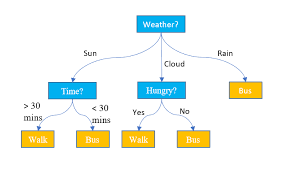

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtModel = DecisionTreeClassifier(random_state = 42)
dtModel.fit(X_train_scaled, y_train)
y_predicted_dt = dtModel.predict(X_test_scaled)

In [ ]:
accuracyScore_DT = accuracy_score(y_test, y_predicted_dt)

print("Decision Tree Model Performance")
print("===============================")
print(f"Accuracy  : {accuracyScore_DT:.4f}")

listModelName.append("Decision Tree")
listAccuracyScore.append(accuracyScore_DT)

## **Decision Tree (Fine Tuned)**

In [ ]:
#
# Example of Hyper-Parameter Tuning
# Produced slightly better results
#
dtModel_FT = DecisionTreeClassifier(max_depth = 4, random_state = 42) # Tuned Hyper-Parameter max_depth
dtModel_FT.fit(X_train_scaled, y_train)
y_predicted_dt_ft = dtModel_FT.predict(X_test_scaled)

In [ ]:
accuracyScore_DT_FT = accuracy_score(y_test, y_predicted_dt_ft)

print("Decision Tree Model Performance (Max Depth = 4)")
print("===============================================")
print(f"Accuracy  : {accuracyScore_DT_FT:.4f}")

listModelName.append("Decision Tree (Fine Tuned)")
listAccuracyScore.append(accuracyScore_DT_FT)

In [ ]:
#
# Exporting Tree
# Decision Tree Fine Tuned Model taken for example
#
# Class (Targt Variable) = 0 (Negative - Not having COVID)
# Class (Targt Variable) = 1 (Positive - Having COVID)
#
from sklearn import tree
treeText = tree.export_text(dtModel_FT)
print(treeText)

In [ ]:
#
# Writing the Tree structure to a File
# File Path = /content/DecisionTree_FineTuned.log
#
with open('DecisionTree_FineTuned.log', 'w') as outFile:
  outFile.write(treeText)

In [ ]:
X.columns

In [ ]:
#
# Visualising tree structure
# Plot using tree
#
features = X.columns
target   = ['0','1'] # Output. Class 0 = Retained, Class 1 = Chruned

fig  = plt.figure(figsize=(20,30))
plot = tree.plot_tree(dtModel_FT,feature_names=features,class_names=target)

fig.savefig('DecisionTree_FineTuned.png')

## **Random Forest**
**More number of decision trees. Using Bagging**

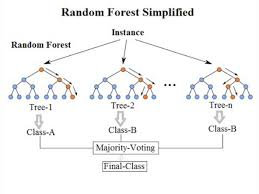

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfModel = RandomForestClassifier(random_state = 42)
rfModel.fit(X_train_scaled, y_train)
y_predicted_rf = rfModel.predict(X_test_scaled)

In [ ]:
accuracyScore_RF = accuracy_score(y_test, y_predicted_dt_ft)

print("Random Forest Model Performance")
print("===============================")
print(f"Accuracy  : {accuracyScore_RF:.4f}")

listModelName.append("Random Forest")
listAccuracyScore.append(accuracyScore_RF)

## **Random Forest (Fine Tuned)**

In [ ]:
rfModel_FT = RandomForestClassifier(n_estimators = 150, random_state = 42)
rfModel_FT.fit(X_train_scaled, y_train)
y_predicted_RF_FT = rfModel.predict(X_test_scaled)

In [ ]:
accuracyScore_RF_FT = accuracy_score(y_test, y_predicted_dt_ft)

print("Random Forest Model Performance (Number of Estimators = 150)")
print("============================================================")
print(f"Accuracy  : {accuracyScore_RF_FT:.4f}")

listModelName.append("Random Forest (Fine Tuned)")
listAccuracyScore.append(accuracyScore_RF_FT)

## **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbModel = GradientBoostingClassifier(random_state = 42)
gbModel.fit(X_train_scaled, y_train)
y_predicted_gb = gbModel.predict(X_test_scaled)

In [ ]:
accuracyScore_GB = accuracy_score(y_test, y_predicted_dt_ft)

print("Gradient Booster Model Performance")
print("==================================")
print(f"Accuracy  : {accuracyScore_GB:.4f}")

listModelName.append("Gradient Booster")
listAccuracyScore.append(accuracyScore_GB)

## **XG Boosting (Extreme Boosting)**

In [ ]:
from xgboost import XGBClassifier
xgbModel = XGBClassifier(random_state = 42)
xgbModel.fit(X_train_scaled, y_train)
y_predicted_xgb = xgbModel.predict(X_test_scaled)

In [ ]:
accuracyScore_XGB = accuracy_score(y_test, y_predicted_xgb)

print("XG Booster Model Performance")
print("============================")
print(f"Accuracy  : {accuracyScore_XGB:.4f}")

listModelName.append("XG Booster")
listAccuracyScore.append(accuracyScore_XGB)

## **Support Vector Machines**

In [ ]:
from sklearn import svm
svmModel = svm.SVC(random_state = 42)
svmModel.fit(X_train_scaled, y_train)
y_predicted_svm = svmModel.predict(X_test_scaled)

In [ ]:
accuracyScore_SVM = accuracy_score(y_test, y_predicted_svm)

print("Support Vector Machines Model Performance")
print("=========================================")
print(f"Accuracy  : {accuracyScore_SVM:.4f}")

listModelName.append("Support Vector Machines")
listAccuracyScore.append(accuracyScore_SVM)

# **Model Comparison**

## **Model Comparison Visualisation**

In [ ]:
#
# Set Pandas display format for floats
#
pd.options.display.float_format = '{:.4f}'.format

#
# Model Comparison Data
#
dictModelComparisonData = {
                            "Model Name"     : listModelName,
                            "Accuracy Score" : listAccuracyScore
                          }

#
# Convert the Dictionary into a DataFrame
#
dfModelComparisonData = pd.DataFrame(dictModelComparisonData)
dfModelComparisonData = dfModelComparisonData.sort_values(
                                                           by        = ['Accuracy Score', 'Model Name'],
                                                           ascending = [False, True]
                                                         )
# print(dfModelComparisonData)

#
# Bar Plot
#
plt.figure(figsize = (13,6))
sns.barplot(
             x       = "Accuracy Score",
             y       = "Model Name",
             data    = dfModelComparisonData,
             hue     = "Model Name", # To supress warning
             palette = "coolwarm" # "Blues_r"
           )

#
# Titles and labels
#
plt.title("Model Accuracy Comparison", fontsize = 18, weight = 'bold')
plt.xlabel("Accuracy Score", fontsize = 12)
plt.ylabel("Model Name", fontsize = 12)

#
# Show values on bars
#
for index, value in enumerate(dfModelComparisonData["Accuracy Score"]):
  plt.text(value + 0.002, index, f"{value:.4f}", va='center')

plt.show()